In [1]:
import os
import pandas as pd
import glob

In [2]:
#configurations
pd.set_option('display.max_colwidth', None)

In [3]:
def get_score_calculation(df):
    # Calculate average score
    avg_score = df['score'].mean()
    # Display some additional statistics
    answer_rate = df['score'].count() / 250
    
    
    adjusted_average_score = avg_score / answer_rate
    return avg_score, adjusted_average_score

def calculate_individual_duration_std_by_group(individual_results):
    """
    Calculate standard deviation of question durations for each group
    """

    group_stats = individual_results.groupby('group_id')['duration'].agg(['mean','std']).reset_index()
    
    group_stats['std_precentage'] = group_stats['std'] / group_stats['mean']

    # Format the output
    group_stats.columns = ['group_id', 'avg_duration', 'std_duration','std_precentage']
    return group_stats

def get_statistics(model_name,combined_id, individual_results, question_sets):

    # אפשרות 2 - sum של ערכים בוליאניים (פשוט יותר)
    correct_answers_count = (individual_results['is_correct'] == True).sum()    
    
    # Count total answered questions (excluding NaN values)
    total_answered_questions = individual_results['is_correct'].notna().sum()
    
    avg_score, adjusted_average_score = get_score_calculation(question_sets)
    group_duration_stats = calculate_individual_duration_std_by_group(individual_results)
    
    # Create a DataFrame instead of a dictionary
    stats_df = pd.DataFrame({
        'model_name': [model_name],
        'failed_to_order': [question_sets['score'].isna().sum()],  # Fixed: count NaN scores only
        'have_score': [question_sets['score'].count()],  # Fixed: count non-NaN scores only
        'correct_individual_answers_count': [correct_answers_count],
        'total_answered_questions': [total_answered_questions],  # New column for total answered questions
        'avg_question_order_score': [avg_score],
        'adjusted_avg_question_order_score': [adjusted_average_score],
        'group_individual_duration_avg': [group_duration_stats['avg_duration'].mean()],
        'group_individual_duration_std': [group_duration_stats['std_duration'].mean()],
        'group_individual_duration_std_percentage': [group_duration_stats['std_precentage'].mean()],
        'group_individual_duration_std_percentage_median': [group_duration_stats['std_precentage'].median()],
        'combined_duration_avg': [question_sets['combined_duration'].mean()],
        'combined_duration_std': [question_sets['combined_duration'].std()]
        
    })
    
    return stats_df

In [4]:

def gather_all_model_statistics():
    # Initialize an empty DataFrame to store all statistics
    all_stats_df = pd.DataFrame()
    
    # Define the base results directories to search
    results_dirs = [
        'results'
    ]
    
    # Traverse each results directory
    for results_dir in results_dirs:
        if not os.path.exists(results_dir):
            print(f"Directory {results_dir} not found, skipping...")
            continue
            
        # Find all model directories (they are 2 levels deep: provider/model)
        provider_dirs = glob.glob(f"{results_dir}/*")
        
        for provider_dir in provider_dirs:
            provider_name = os.path.basename(provider_dir)
            model_dirs = glob.glob(f"{provider_dir}/*")
            
            for model_dir in model_dirs:
                model_name = os.path.basename(model_dir)
                full_model_name = f"{provider_name}/{model_name}"
                #print(f"Processing model: {full_model_name}")
                
                # Check if all required files exist
                combined_ids_path = os.path.join(model_dir, "combined_ids.csv")
                individual_results_path = os.path.join(model_dir, "individual_results.csv")
                question_sets_path = os.path.join(model_dir, "question_sets.csv")
                
                if not all(os.path.exists(path) for path in [combined_ids_path, individual_results_path, question_sets_path]):
                    print(f"Missing required files for {full_model_name}, skipping...")
                    continue
                
                try:
                    # Load the data
                    combined_ids = pd.read_csv(combined_ids_path)
                    individual_results = pd.read_csv(individual_results_path)
                    question_sets = pd.read_csv(question_sets_path)
                    
                    # Get statistics for this model
                    stats_df = get_statistics(full_model_name, combined_ids, individual_results, question_sets)
                    
                    # Append to the combined DataFrame
                    all_stats_df = pd.concat([all_stats_df, stats_df], ignore_index=True)
                    
                except Exception as e:
                    print(f"Error processing {full_model_name}: {str(e)}")
    
    return all_stats_df

# Example usage
if __name__ == "__main__":
    # Gather all statistics
    all_stats = gather_all_model_statistics()
    
    # Display the combined table
    display(all_stats)
    
    # Save to CSV
    input("should I save the statistics to a CSV file? (y/n): ")
    if input().strip().lower() == 'y':
        all_stats.to_csv('all_model_statistics.csv', index=False)
        print("Statistics saved to all_model_statistics.csv")

,model_name,failed_to_order,have_score,correct_individual_answers_count,total_answered_questions,avg_question_order_score,adjusted_avg_question_order_score,group_individual_duration_avg,group_individual_duration_std,group_individual_duration_std_percentage,group_individual_duration_std_percentage_median,combined_duration_avg,combined_duration_std
0,qwen/qwen-2.5-7b-instruct,3,247,691,1000,0.600540,0.607834,292.506000,135.982075,0.447829,0.436050,308.604000,90.842018
1,google/gemini-2.5-flash-preview,0,250,696,1000,0.676667,0.676667,1688.928000,2606.143693,0.793060,0.690027,1284.780000,501.746664
2,google/gemini-2.5-pro-preview,14,236,830,944,0.710452,0.752597,2738.866740,1853.964057,0.592662,0.540213,5547.737288,2484.729651
3,openai/o4-mini-2025-04-16,0,250,861,1000,0.673333,0.673333,461.824580,273.324389,0.533337,0.488096,960.892000,359.803215
4,openai/gpt-4.1-2025-04-14,1,249,883,1000,0.734270,0.737219,536.547000,714.048273,0.539372,0.428505,470.200000,96.293352
5,openai/gpt-4.1-mini,0,250,880,1000,0.704000,0.704000,274.173000,167.252314,0.563538,0.532192,534.992000,107.740727
6,mistralai/mistral-7b-instruct,63,187,504,1000,0.549020,0.733983,322.258000,288.077790,0.547520,0.515394,333.912000,101.628073
7,mistralai/mistral-small-3.1-24b-instruct,6,244,803,1000,0.599044,0.613774,292.021000,134.716397,0.432727,0.402310,338.548000,81.367922
8,anthropic/claude-3.7-sonnet-thinking,20,230,813,920,0.747826,0.812854,3233.643665,3601.199900,0.995522,1.023823,4764.221739,2595.280192
9,anthropic/claude-3.5-haiku,0,250,761,1000,0.674667,0.674667,259.021000,49.995558,0.189060,0.169755,279.116000,24.311040


Statistics saved to all_model_statistics.csv


In [5]:
temp = pd.read_csv('results/google/gemini-2.5-pro-preview/question_sets.csv')
display(temp)

group_id  llm_ranking  \
0    MMLU_ARRANGED_GROUP_038  Q1,Q2,Q3,Q4   
1    MMLU_ARRANGED_GROUP_068  Q1,Q3,Q4,Q2   
2    MMLU_ARRANGED_GROUP_072  Q2,Q4,Q1,Q3   
3    MMLU_ARRANGED_GROUP_075  Q1,Q2,Q3,Q4   
4    MMLU_ARRANGED_GROUP_076  Q4,Q3,Q2,Q1   
..                       ...          ...   
245  MMLU_ARRANGED_GROUP_245  Q2,Q3,Q1,Q4   
246  MMLU_ARRANGED_GROUP_246  Q3,Q4,Q2,Q1   
247  MMLU_ARRANGED_GROUP_247  Q3,Q1,Q4,Q2   
248  MMLU_ARRANGED_GROUP_249  Q3,Q1,Q2,Q4   
249  MMLU_ARRANGED_GROUP_250  Q4,Q1,Q2,Q3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [6]:
filtered_stats_df = all_stats[all_stats['failed_to_order'] > 0]
display(filtered_stats_df[['model_name','failed_to_order']])

,model_name,failed_to_order
0,qwen/qwen-2.5-7b-instruct,3
2,google/gemini-2.5-pro-preview,14
4,openai/gpt-4.1-2025-04-14,1
6,mistralai/mistral-7b-instruct,63
7,mistralai/mistral-small-3.1-24b-instruct,6
8,anthropic/claude-3.7-sonnet-thinking,20
11,meta-llama/llama-3.2-3b-instruct,63
12,meta-llama/llama-3.1-8b-instruct,24


In [7]:
display(all_stats[all_stats['model_name'].str.contains('google')])

,model_name,failed_to_order,have_score,correct_individual_answers_count,total_answered_questions,avg_question_order_score,adjusted_avg_question_order_score,group_individual_duration_avg,group_individual_duration_std,group_individual_duration_std_percentage,group_individual_duration_std_percentage_median,combined_duration_avg,combined_duration_std
1,google/gemini-2.5-flash-preview,0,250,696,1000,0.676667,0.676667,1688.92800,2606.143693,0.793060,0.690027,1284.780000,501.746664
2,google/gemini-2.5-pro-preview,14,236,830,944,0.710452,0.752597,2738.86674,1853.964057,0.592662,0.540213,5547.737288,2484.729651


In [8]:
# Load the question_sets_backup.csv for llama-3.2-3b-instruct
backup_path = 'results/meta-llama/llama-3.2-3b-instruct/question_sets_backup.csv'
current_path = 'results/meta-llama/llama-3.2-3b-instruct/question_sets.csv'

try:
    # Load both datasets
    backup_df = pd.read_csv(backup_path)
    current_df = pd.read_csv(current_path)
    
    print(f"Backup dataset shape: {backup_df.shape}")
    print(f"Current dataset shape: {current_df.shape}")
    
    # Compare the number of groups
    print(f"\nNumber of unique groups in backup: {backup_df['group_id'].nunique()}")
    print(f"Number of unique groups in current: {current_df['group_id'].nunique()}")
    
    # Compare scoring statistics
    print("\nScore statistics comparison:")
    print(f"Backup mean score: {backup_df['score'].mean():.4f}")
    print(f"Current mean score: {current_df['score'].mean():.4f}")
    print(f"Backup NaN scores: {backup_df['score'].isna().sum()}")
    print(f"Current NaN scores: {current_df['score'].isna().sum()}")
    
    # Find groups that exist in one dataset but not the other
    backup_groups = set(backup_df['group_id'])
    current_groups = set(current_df['group_id'])
    
    missing_in_current = backup_groups - current_groups
    missing_in_backup = current_groups - backup_groups
    
    print(f"\nGroups in backup but not in current: {len(missing_in_current)}")
    if len(missing_in_current) > 0:
        print(f"Example missing groups: {list(missing_in_current)[:5]}")
    
    print(f"\nGroups in current but not in backup: {len(missing_in_backup)}")
    if len(missing_in_backup) > 0:
        print(f"Example missing groups: {list(missing_in_backup)[:5]}")
    
    # Check for differences in scores for common groups
    common_groups = backup_groups.intersection(current_groups)
    print(f"\nNumber of common groups: {len(common_groups)}")
    
    if len(common_groups) > 0:
        # Create DataFrames with just the common groups
        backup_common = backup_df[backup_df['group_id'].isin(common_groups)]
        current_common = current_df[current_df['group_id'].isin(common_groups)]
        
        # Merge to compare scores
        merged = pd.merge(backup_common[['group_id', 'score']], 
                         current_common[['group_id', 'score']], 
                         on='group_id', 
                         suffixes=('_backup', '_current'))
        
        # Calculate score differences
        merged['score_diff'] = merged['score_current'] - merged['score_backup']
        
        # Count groups with different scores
        diff_count = (merged['score_diff'] != 0).sum()
        print(f"Groups with different scores: {diff_count}")
        
        if diff_count > 0:
            print("\nExample groups with different scores:")
            display(merged[merged['score_diff'] != 0].head())
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("One or both of the files could not be found. Check the paths.")
except Exception as e:
    print(f"Error occurred: {e}")

Backup dataset shape: (250, 8)
Current dataset shape: (250, 8)

Number of unique groups in backup: 250
Number of unique groups in current: 250

Score statistics comparison:
Backup mean score: 0.5667
Current mean score: 0.5463
Backup NaN scores: 185
Current NaN scores: 63

Groups in backup but not in current: 0

Groups in current but not in backup: 0

Number of common groups: 250
Groups with different scores: 185

Example groups with different scores:


,group_id,score_backup,score_current,score_diff
0,MMLU_ARRANGED_GROUP_001,NaN,NaN,NaN
1,MMLU_ARRANGED_GROUP_002,NaN,NaN,NaN
3,MMLU_ARRANGED_GROUP_004,NaN,0.833333,NaN
4,MMLU_ARRANGED_GROUP_005,NaN,0.666667,NaN
5,MMLU_ARRANGED_GROUP_006,NaN,0.833333,NaN


In [9]:
# Clear and re-collect the data with the updated function
all_stats = gather_all_model_statistics()

print("Columns after re-collection:")
print(all_stats.columns.tolist())

# Check if the new column exists
if 'total_answered_questions' in all_stats.columns:
    # Calculate individual answer accuracy rate
    all_stats['individual_answer_accuracy_rate'] = (all_stats['correct_individual_answers_count'] / all_stats['total_answered_questions'] * 100).round(2)
    
    # Display the enhanced statistics
    display(all_stats[['model_name', 'correct_individual_answers_count', 'total_answered_questions', 'individual_answer_accuracy_rate', 'failed_to_order']])
    
    print(f"\nSummary:")
    print(f"Models with best individual answer accuracy:")
    best_models = all_stats.nlargest(3, 'individual_answer_accuracy_rate')
    for _, row in best_models.iterrows():
        print(f"  {row['model_name']}: {row['individual_answer_accuracy_rate']}% ({row['correct_individual_answers_count']}/{row['total_answered_questions']})")
        
else:
    print("Still no 'total_answered_questions' column found!")
    # Let's debug by looking at a single model's statistics
    print("\nTrying to debug by running get_statistics manually on one model...")
    
    # Try to manually call get_statistics to see what it returns
    import pandas as pd
    import os
    
    # Pick the first available model to test
    test_model_path = 'results/anthropic/claude-3.5-haiku'
    if os.path.exists(test_model_path):
        combined_ids = pd.read_csv(os.path.join(test_model_path, 'combined_ids.csv'))
        individual_results = pd.read_csv(os.path.join(test_model_path, 'individual_results.csv'))
        question_sets = pd.read_csv(os.path.join(test_model_path, 'question_sets.csv'))
        
        debug_stats = get_statistics('test_model', combined_ids, individual_results, question_sets)
        print("Debug stats columns:", debug_stats.columns.tolist())
        display(debug_stats)

Columns after re-collection:
['model_name', 'failed_to_order', 'have_score', 'correct_individual_answers_count', 'total_answered_questions', 'avg_question_order_score', 'adjusted_avg_question_order_score', 'group_individual_duration_avg', 'group_individual_duration_std', 'group_individual_duration_std_percentage', 'group_individual_duration_std_percentage_median', 'combined_duration_avg', 'combined_duration_std']


,model_name,correct_individual_answers_count,total_answered_questions,individual_answer_accuracy_rate,failed_to_order
0,qwen/qwen-2.5-7b-instruct,691,1000,69.10,3
1,google/gemini-2.5-flash-preview,696,1000,69.60,0
2,google/gemini-2.5-pro-preview,830,944,87.92,14
3,openai/o4-mini-2025-04-16,861,1000,86.10,0
4,openai/gpt-4.1-2025-04-14,883,1000,88.30,1
5,openai/gpt-4.1-mini,880,1000,88.00,0
6,mistralai/mistral-7b-instruct,504,1000,50.40,63
7,mistralai/mistral-small-3.1-24b-instruct,803,1000,80.30,6
8,anthropic/claude-3.7-sonnet-thinking,813,920,88.37,20
9,anthropic/claude-3.5-haiku,761,1000,76.10,0



Summary:
Models with best individual answer accuracy:
  deepseek/deepseek-r1: 90.3% (903/1000)
  anthropic/claude-3.7-sonnet-thinking: 88.37% (813/920)
  openai/gpt-4.1-2025-04-14: 88.3% (883/1000)


In [10]:
def clean_model_name(model_name):
    """
    Clean model names to show only the essential model identifier.
    Uses regex to remove date patterns and other common suffixes.
    """
    import re
    
    if pd.isna(model_name) or model_name == "":
        return model_name
   
    # Convert to lowercase for processing
    name = str(model_name).lower()
    name = name.replace('/', '-')
    
    # Remove common prefixes
    prefixes_to_remove = ['anthropic-', 'google-', 'openai-', 'meta-', 'deepseek-', 'mistralai-', 'qwen-',
                          'anthropic/', 'google/', 'openai/', 'meta/', 'deepseek/', 'mistralai/', 'qwen/']
    for prefix in prefixes_to_remove:
        if name.startswith(prefix):
            name = name[len(prefix):]
            break
    
    # Remove duplicate company names (e.g., "qwen-qwen-2.5" -> "qwen-2.5")
    parts = name.split('-')
    if len(parts) > 1 and parts[0] == parts[1]:
        parts = parts[1:]
        name = '-'.join(parts)
    
    # Use regex to remove date patterns at the end of model names
    # This will match patterns like: -2025-04-16, -0324, -03-25, etc.
    name = re.sub(r'-\d{4}-\d{2}-\d{2}$', '', name)  # yyyy-mm-dd format
    name = re.sub(r'-\d{2}-\d{2}$', '', name)        # mm-dd format
    name = re.sub(r'-\d{4}$', '', name)              # yyyy format
    name = re.sub(r'-\d{6}$', '', name)              # yyyymm format
    name = re.sub(r'-\d{8}$', '', name)              # yyyymmdd format
    
    # Remove other common suffixes
    suffixes_to_remove = ['-instruct', '-chat', '-preview', '-thinking', '-001']
    for suffix in suffixes_to_remove:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
            break
    
    # Replace hyphens with spaces and clean up
    name = name.replace('-', ' ')
    
    # Remove extra words that don't add value
    words_to_remove = ['instruct', 'chat', 'preview', 'thinking']
    words = name.split()
    words = [word for word in words if word not in words_to_remove]
    
    # Join and capitalize appropriately
    cleaned_name = ' '.join(words)
    
    # Special handling for specific models
    if 'claude' in cleaned_name:
        cleaned_name = cleaned_name.replace('claude', 'Claude')
    elif 'gemini' in cleaned_name:
        cleaned_name = cleaned_name.replace('gemini', 'Gemini')
    elif 'gpt' in cleaned_name:
        cleaned_name = cleaned_name.replace('gpt', 'GPT')
    elif 'llama' in cleaned_name:
        cleaned_name = cleaned_name.replace('llama', 'Llama')
    elif 'qwen' in cleaned_name:
        cleaned_name = cleaned_name.replace('qwen', 'Qwen')
    elif 'mistral' in cleaned_name or 'mistralai' in cleaned_name:
        cleaned_name = cleaned_name.title()
    elif 'deepseek' in cleaned_name:
        cleaned_name = cleaned_name.replace('deepseek', 'DeepSeek')
    
    return cleaned_name

,model_name,failed_to_order,have_score,correct_individual_answers_count,total_answered_questions,avg_question_order_score,adjusted_avg_question_order_score,group_individual_duration_avg,group_individual_duration_std,group_individual_duration_std_percentage,group_individual_duration_std_percentage_median,combined_duration_avg,combined_duration_std,individual_answer_accuracy_rate
0,Qwen 2.5 7b,3,247,691,1000,0.600540,0.607834,292.506000,135.982075,0.447829,0.436050,308.604000,90.842018,69.10
1,Gemini 2.5 flash,0,250,696,1000,0.676667,0.676667,1688.928000,2606.143693,0.793060,0.690027,1284.780000,501.746664,69.60
2,Gemini 2.5 pro,14,236,830,944,0.710452,0.752597,2738.866740,1853.964057,0.592662,0.540213,5547.737288,2484.729651,87.92
3,o4 mini,0,250,861,1000,0.673333,0.673333,461.824580,273.324389,0.533337,0.488096,960.892000,359.803215,86.10
4,GPT 4.1,1,249,883,1000,0.734270,0.737219,536.547000,714.048273,0.539372,0.428505,470.200000,96.293352,88.30
5,GPT 4.1 mini,0,250,880,1000,0.704000,0.704000,274.173000,167.252314,0.563538,0.532192,534.992000,107.740727,88.00
6,Mistral 7B,63,187,504,1000,0.549020,0.733983,322.258000,288.077790,0.547520,0.515394,333.912000,101.628073,50.40
7,Mistral Small 3.1 24B,6,244,803,1000,0.599044,0.613774,292.021000,134.716397,0.432727,0.402310,338.548000,81.367922,80.30
8,Claude 3.7 sonnet,20,230,813,920,0.747826,0.812854,3233.643665,3601.199900,0.995522,1.023823,4764.221739,2595.280192,88.37
9,Claude 3.5 haiku,0,250,761,1000,0.674667,0.674667,259.021000,49.995558,0.189060,0.169755,279.116000,24.311040,76.10


/tmp/ipykernel_43038/4289787967.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(sorted_stats['model_name'], rotation=45, ha='right')
/tmp/ipykernel_43038/4289787967.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(sorted_stats['model_name'], rotation=45, ha='right')


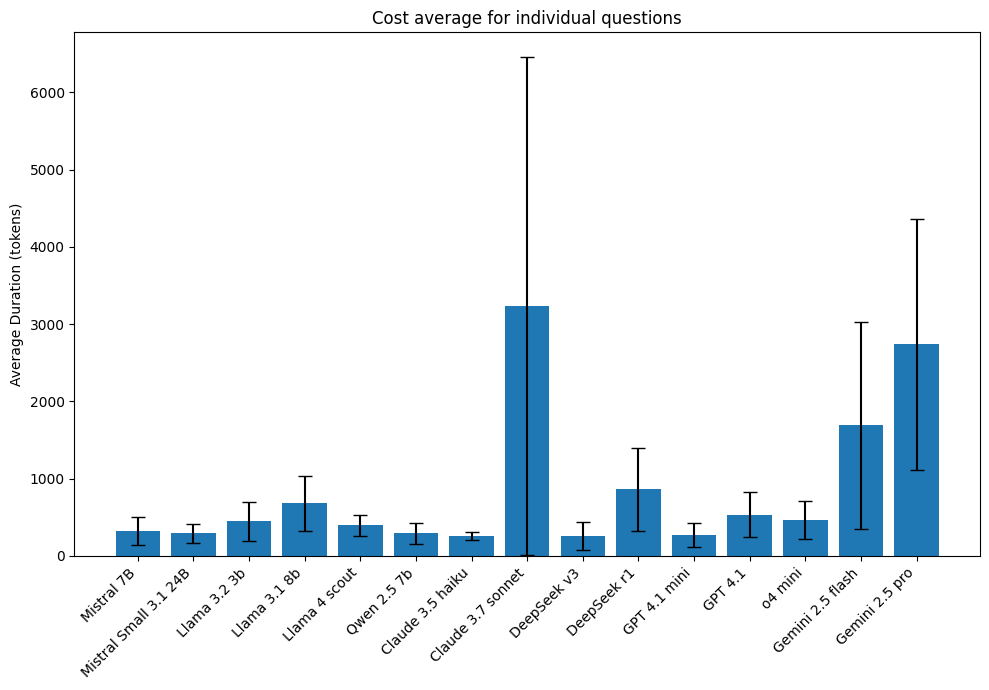

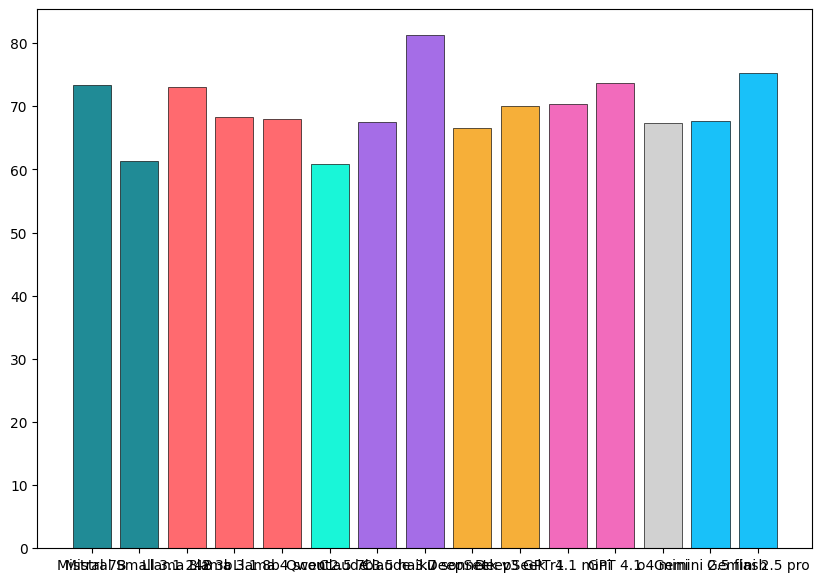

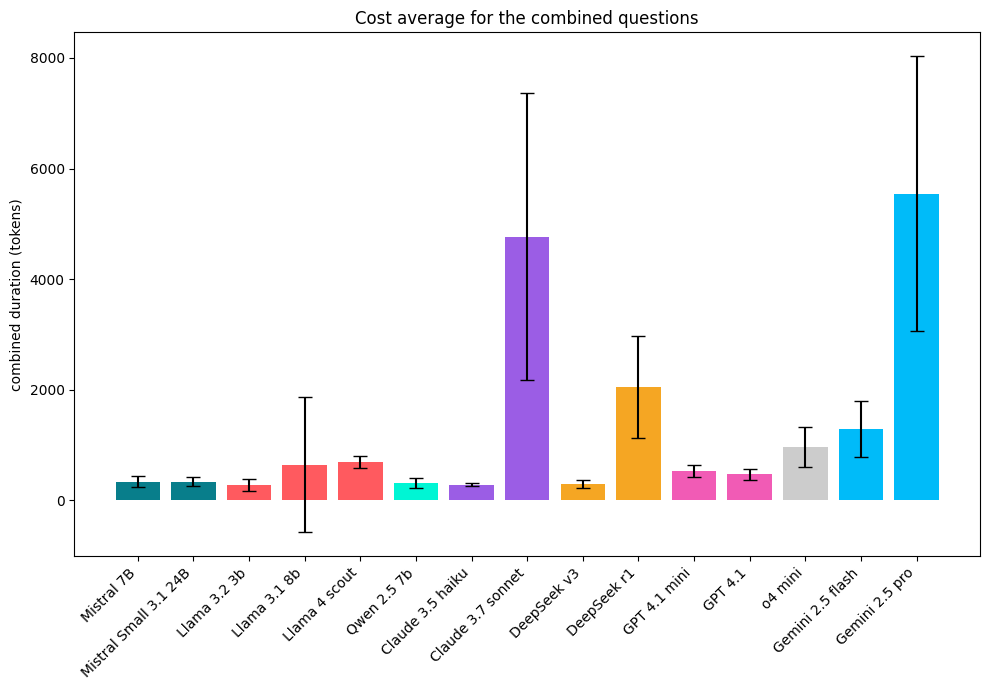

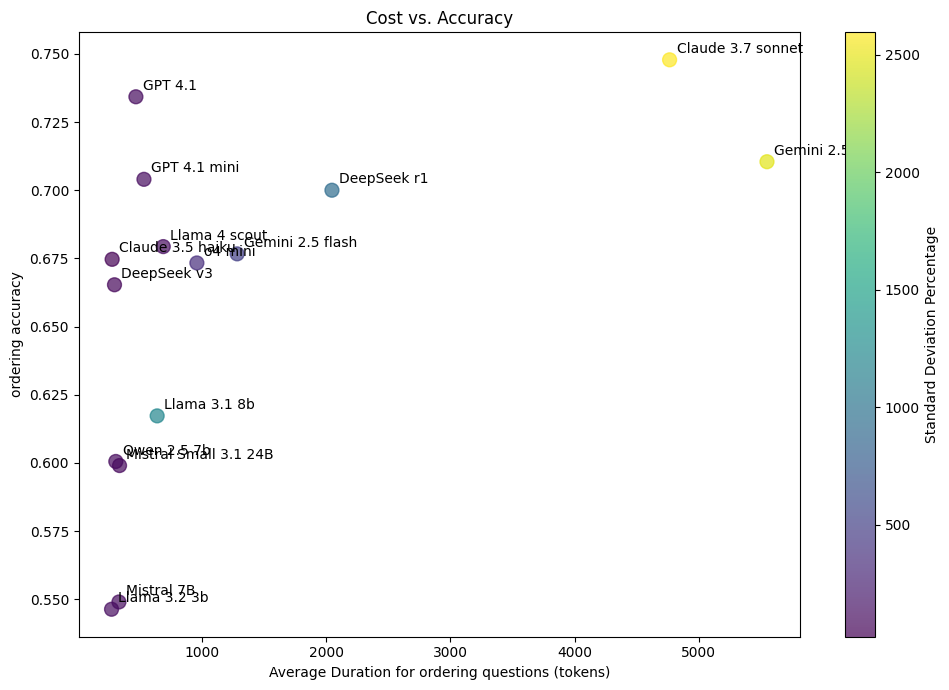

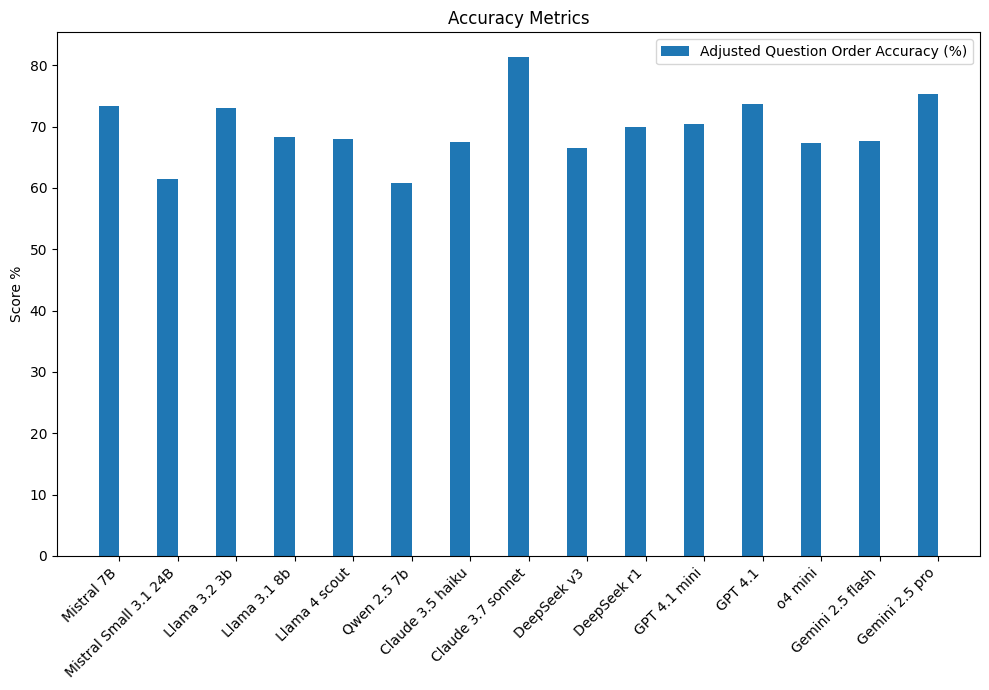

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def visualize_model_performance(all_stats):
    # Sort by a key metric (e.g., accuracy or duration)

    sorted_stats = all_stats.copy()
    sorted_stats['model_name'] = sorted_stats['model_name'].apply(clean_model_name)
    
    display(sorted_stats)
    sorted_models = {'Mistral 7B': 0, 'Mistral Small 3.1 24B': 1, 'Llama 3.2 3b': 2, 'Llama 3.1 8b': 3, 'Llama 4 scout': 4, 'Qwen 2.5 7b': 5, 'Claude 3.5 haiku': 6, 'Claude 3.7 sonnet': 7, 'DeepSeek v3': 8, 'DeepSeek r1': 9, 'GPT 4.1 mini': 10, 'GPT 4.1': 11, 'o4 mini': 12, 'Gemini 2.5 flash': 13, 'Gemini 2.5 pro': 14}
    model_order_df = pd.DataFrame({
        'model_name': list(sorted_models.keys()),
        'order': list(sorted_models.values())
    })

    # Merge the order information with your stats DataFrame
    sorted_stats = pd.merge(
        sorted_stats,
        model_order_df,
        on='model_name',
        how='left'
    )

    # Sort by the order column
    sorted_stats = sorted_stats.sort_values('order')

    # Create separate figures for each plot
    figures = []
    
    # Figure 1: Accuracy metrics
    fig1, ax1 = plt.subplots(figsize=(10, 7))
    x = np.arange(len(sorted_stats))
    width = 0.35
    ax1.bar(x - width/2, sorted_stats['adjusted_avg_question_order_score']* 100, width, label='Adjusted Question Order Accuracy (%)')
    # ax1.bar(x + width/2, sorted_stats['avg_question_order_score'] * 100, width, label='Question Order Accuracy (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_stats['model_name'], rotation=45, ha='right')
    ax1.set_ylabel('Score %')
    ax1.set_title('Accuracy Metrics')
    ax1.legend()
    plt.tight_layout()
    plt.savefig('accuracy_metrics.png', dpi=300, bbox_inches='tight')
    figures.append(fig1)
    
    # Figure 2: Duration metrics for individual questions
    fig2, ax2 = plt.subplots(figsize=(10, 7))
    ax2.bar(sorted_stats['model_name'], sorted_stats['group_individual_duration_avg'], 
            yerr=sorted_stats['group_individual_duration_std_percentage']*sorted_stats['group_individual_duration_avg'], capsize=5)
    ax2.set_xticklabels(sorted_stats['model_name'], rotation=45, ha='right')
    ax2.set_ylabel('Average Duration (tokens)')
    ax2.set_title('Cost average for individual questions')
    plt.tight_layout()
    plt.savefig('individual_duration.png', dpi=300, bbox_inches='tight')
    figures.append(fig2)
    

    # צבעים לפי משפחות מודלים
    model_colors = {
        'Claude': '#9B5DE5',
        'GPT': '#F15BB5',
        'Gemini': '#00BBF9',
        'Llama': '#FF5A5F',
        'Mistral': '#087E8B',
        'DeepSeek': '#F5A623',
        'Qwen': '#00F5D4'
    }

    # פונקציה לבחירת צבע לפי שם המודל
    def get_model_color(model_name):
        for key in model_colors:
            if key in model_name:
                return model_colors[key]
        return '#CCCCCC'  # צבע ברירת מחדל

    # צור מערך צבעים לפי שמות המודלים
    model_specific_colors = [get_model_color(name) for name in sorted_stats['model_name']]

    # השתמש בצבעים הספציפיים בגרף
    plt.figure(figsize=(10, 7))
    plt.bar(sorted_stats['model_name'], sorted_stats['adjusted_avg_question_order_score'] * 100,
            color=model_specific_colors, alpha=0.9, edgecolor='black', linewidth=0.5)
    
    # Figure 3: Duration metrics for combined questions
    fig3, ax3 = plt.subplots(figsize=(10, 7))
    ax3.bar(sorted_stats['model_name'], sorted_stats['combined_duration_avg'], 
            yerr=sorted_stats['combined_duration_std'], capsize=5, color = model_specific_colors)
    ax3.set_xticklabels(sorted_stats['model_name'], rotation=45, ha='right')
    ax3.set_ylabel('combined duration (tokens)')
    ax3.set_title('Cost average for the combined questions')
    plt.tight_layout()
    plt.savefig('combined_duration.png', dpi=300, bbox_inches='tight')
    figures.append(fig3)
    
    # Figure 4: Scatter plot of accuracy vs. duration
    fig4, ax4 = plt.subplots(figsize=(10, 7))
    scatter = ax4.scatter(
        sorted_stats['combined_duration_avg'], 
        sorted_stats['avg_question_order_score'],
        s=100,  # Marker size
        c=sorted_stats['combined_duration_std'],  # Color by std percentage
        cmap='viridis',
        alpha=0.7
    )
    
    # Add model names as annotations
    for i, model in enumerate(sorted_stats['model_name']):
        ax4.annotate(model, 
                    (sorted_stats['combined_duration_avg'].iloc[i], 
                     sorted_stats['avg_question_order_score'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')
    
    ax4.set_xlabel('Average Duration for ordering questions (tokens)')
    ax4.set_ylabel('ordering accuracy')
    ax4.set_title('Cost vs. Accuracy')
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Standard Deviation Percentage')
    plt.tight_layout()
    plt.savefig('cost_vs_accuracy.png', dpi=300, bbox_inches='tight')
    figures.append(fig4)
    
    return figures

# Call the function with the all_stats DataFrame
figures = visualize_model_performance(all_stats)

# Display each plot separately
for fig in figures:
    plt.figure(fig.number)
    plt.show()

In [12]:
model_to_duration = all_stats[['model_name', 'group_individual_duration_avg', 'group_individual_duration_std']].copy()

display(model_to_duration)

,model_name,group_individual_duration_avg,group_individual_duration_std
0,qwen/qwen-2.5-7b-instruct,292.506000,135.982075
1,google/gemini-2.5-flash-preview,1688.928000,2606.143693
2,google/gemini-2.5-pro-preview,2738.866740,1853.964057
3,openai/o4-mini-2025-04-16,461.824580,273.324389
4,openai/gpt-4.1-2025-04-14,536.547000,714.048273
5,openai/gpt-4.1-mini,274.173000,167.252314
6,mistralai/mistral-7b-instruct,322.258000,288.077790
7,mistralai/mistral-small-3.1-24b-instruct,292.021000,134.716397
8,anthropic/claude-3.7-sonnet-thinking,3233.643665,3601.199900
9,anthropic/claude-3.5-haiku,259.021000,49.995558


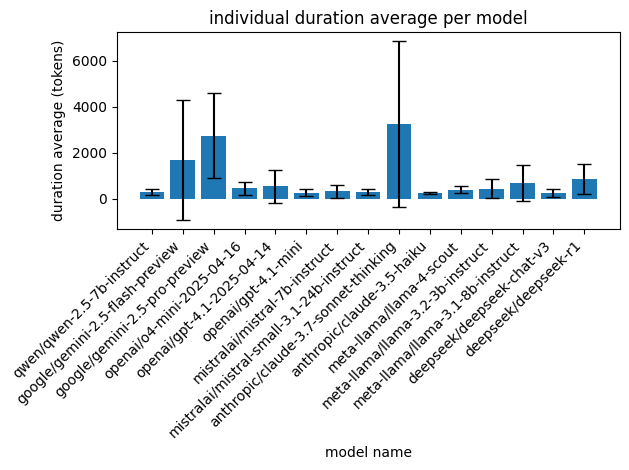

In [13]:
# גרף עמודות
plt.bar(model_to_duration['model_name'], model_to_duration['group_individual_duration_avg'], yerr=model_to_duration['group_individual_duration_std'], capsize=5)

# תוויות וצירים
plt.xlabel('model name')
plt.xticks(rotation=45, ha='right')
plt.ylabel('duration average (tokens)')
plt.title('individual duration average per model')
plt.tight_layout()

plt.show()

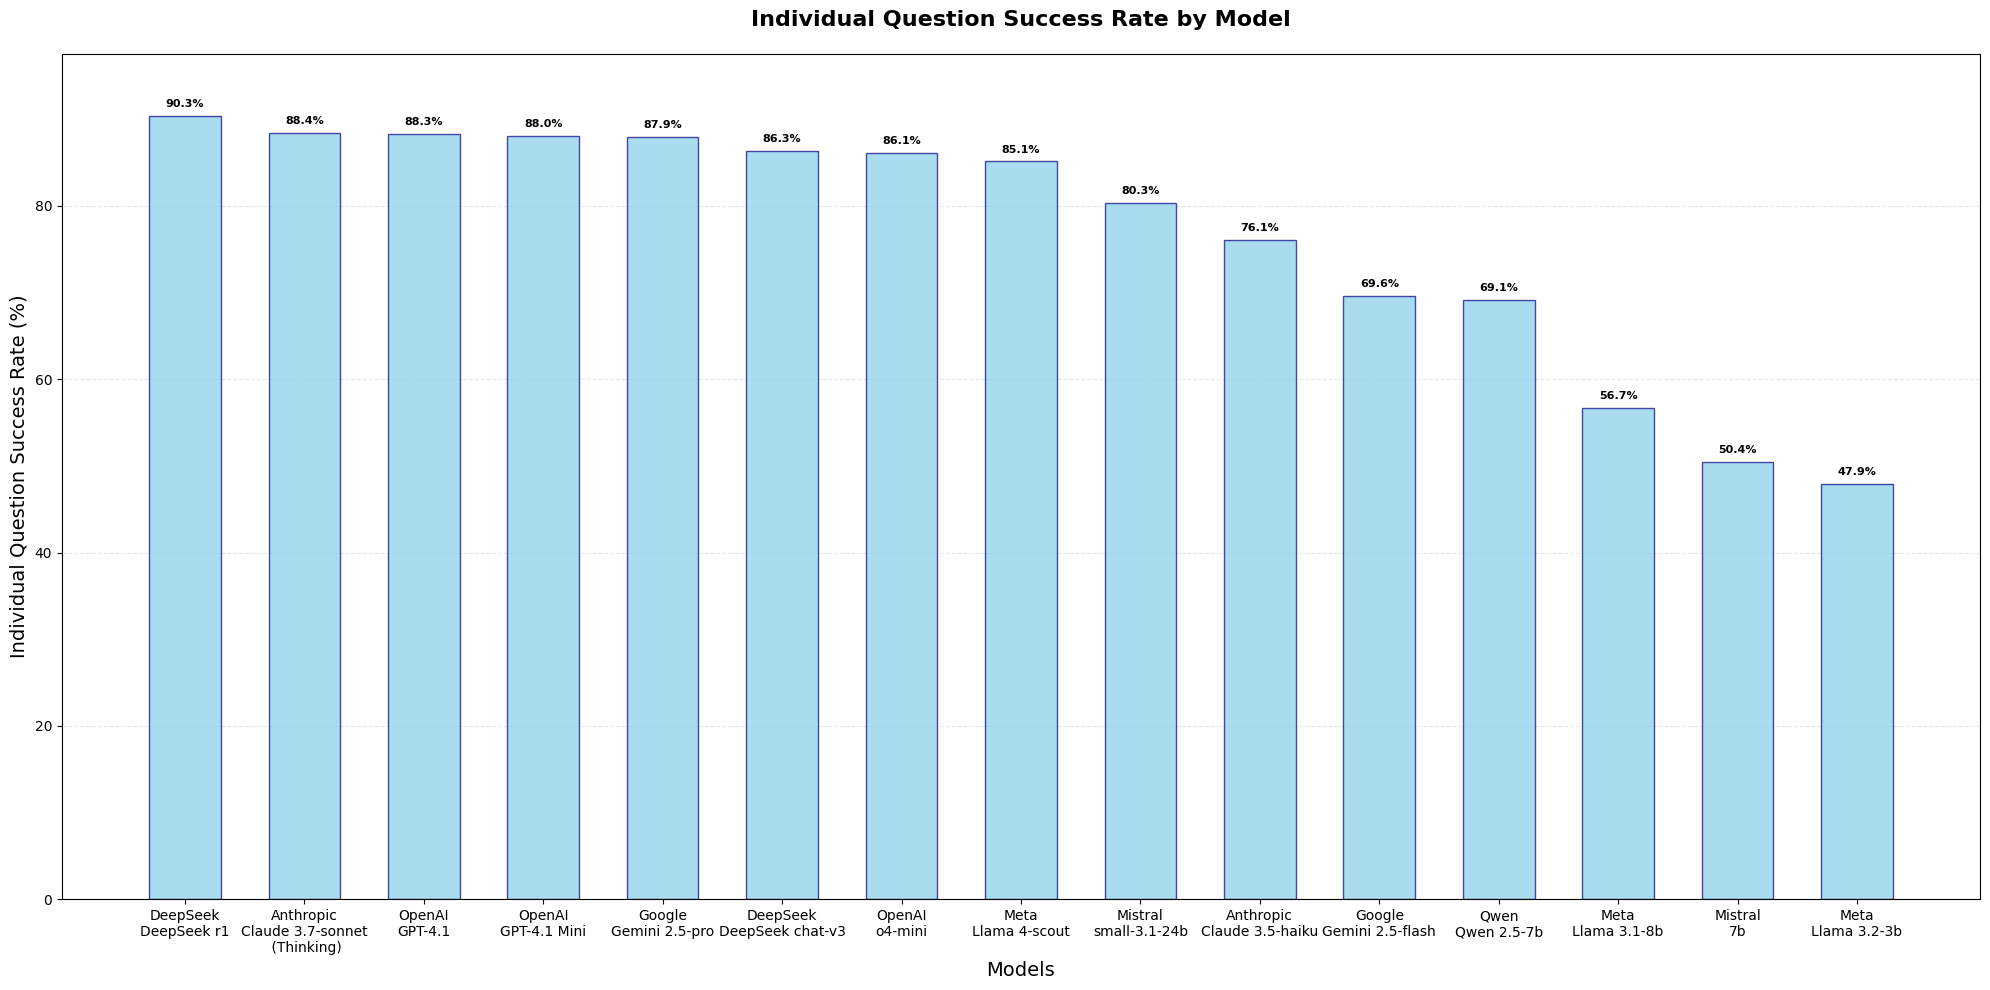


Summary Statistics for Individual Question Success Rate:
Mean: 76.70%
Median: 85.10%
Standard Deviation: 14.65%
Range: 47.90% - 90.30%


In [14]:
# Create vertical bar chart of individual question success rates
import matplotlib.pyplot as plt
import numpy as np

def format_model_name(model_name):
    """Format model name for cleaner display"""
    # Split by slash and take parts
    if '/' in model_name:
        provider, model = model_name.split('/', 1)
        # Clean up provider names
        provider = provider.replace('meta-llama', 'Meta').replace('anthropic', 'Anthropic')\
                          .replace('openai', 'OpenAI').replace('google', 'Google')\
                          .replace('deepseek', 'DeepSeek').replace('mistralai', 'Mistral')\
                          .replace('qwen', 'Qwen')
        # Clean up model names - remove common prefixes and simplify
        model = model.replace('claude-', 'Claude ').replace('gpt-', 'GPT-')\
                    .replace('gemini-', 'Gemini ').replace('llama-', 'Llama ')\
                    .replace('mistral-', '').replace('deepseek-', 'DeepSeek ')\
                    .replace('qwen-', 'Qwen ').replace('-instruct', '')\
                    .replace('-preview', '').replace('-thinking', '\n (Thinking)')\
                    .replace('-2025-04-14', '').replace('-2025-04-16', '')\
                    .replace('4.1-2025-04-14', '4.1').replace('4.1-mini', '4.1 Mini')
        return f"{provider}\n{model}"
    return model_name

# Sort models by success rate (descending for better visual impact)
sorted_stats = all_stats.sort_values('individual_answer_accuracy_rate', ascending=False)

# Format model names
formatted_names = [format_model_name(name) for name in sorted_stats['model_name']]

# Create figure and axis - increased figure size and adjusted proportions
fig, ax = plt.subplots(figsize=(20, 10))

# Create vertical bar chart with more spacing
bars = ax.bar(range(len(sorted_stats)), sorted_stats['individual_answer_accuracy_rate'], 
              color='skyblue', edgecolor='navy', alpha=0.7, width=0.6)

# Customize the plot with better terminology
ax.set_xticks(range(len(sorted_stats)))
ax.set_xticklabels(formatted_names, fontsize=10, ha='center', rotation=0)
ax.set_ylabel('Individual Question Success Rate (%)', fontsize=14)
ax.set_xlabel('Models', fontsize=14)
ax.set_title('Individual Question Success Rate by Model', fontsize=16, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, sorted_stats['individual_answer_accuracy_rate'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8, f'{value:.1f}%', 
            ha='center', va='bottom', fontsize=8, fontweight='bold')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Set y-axis limits with more padding for labels
ax.set_ylim(0, max(sorted_stats['individual_answer_accuracy_rate']) * 1.08)

# Increase spacing between x-axis labels and bottom of plot
plt.subplots_adjust(bottom=0.15)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot with updated name
plt.savefig('plots/individual_question_success_rate.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics with updated terminology
print(f"\nSummary Statistics for Individual Question Success Rate:")
print(f"Mean: {sorted_stats['individual_answer_accuracy_rate'].mean():.2f}%")
print(f"Median: {sorted_stats['individual_answer_accuracy_rate'].median():.2f}%")
print(f"Standard Deviation: {sorted_stats['individual_answer_accuracy_rate'].std():.2f}%")
print(f"Range: {sorted_stats['individual_answer_accuracy_rate'].min():.2f}% - {sorted_stats['individual_answer_accuracy_rate'].max():.2f}%")

# This one is detecting the unparceble format

In [15]:
import pandas as pd
import numpy as np

# File path for the question_sets.csv
question_sets_file = 'results18-05-25\\meta-llama\\llama-3.1-8b-instruct\\question_sets.csv'

# Load the CSV file
try:
    df_question_sets = pd.read_csv(question_sets_file)
except FileNotFoundError:
    print(f"Error: The file {question_sets_file} was not found.")
    df_question_sets = None

if df_question_sets is not None:
    # Initialize a counter for ranking format errors
    ranking_format_errors = 0
    
    # Define the specific failure string to exclude
    llm_call_failure_string = "Combined prompt LLM call failed or returned no answer"
    
    for index, row in df_question_sets.iterrows():
        llm_ranking = row.get('llm_ranking')
        raw_output = row.get('raw_llm_ranking_output')
        
        # Check if llm_ranking is NaN (which pandas uses for empty/missing) or an empty string
        is_llm_ranking_empty = pd.isna(llm_ranking) or llm_ranking == ''
        
        # Check if raw_output is not NaN and not the specific failure string
        is_raw_output_valid_for_error = pd.notna(raw_output) and raw_output != llm_call_failure_string and raw_output != ''
        
        if is_llm_ranking_empty and is_raw_output_valid_for_error:
            ranking_format_errors += 1
            
    print(f"Number of times the model provided ranking output in an unparsable format: {ranking_format_errors}")

    # Display the first few rows to verify columns and content
    print("\nFirst 5 rows of the question_sets DataFrame:")
    print(df_question_sets.head())
else:
    print("DataFrame could not be loaded. Cannot perform analysis.")

Error: The file results18-05-25\meta-llama\llama-3.1-8b-instruct\question_sets.csv was not found.
DataFrame could not be loaded. Cannot perform analysis.


# Find and Extract Failed Question Groups for Re-processing

This section helps identify question groups that failed to process properly in prior runs, so they can be re-processed.

In [16]:
def find_failed_groups(model_path, arranged_questions_path='arranged_question_sets.csv'):
    """
    Identify question groups that failed to process properly for a specific model.
    
    Args:
        model_path: Path to the model's result directory (e.g., 'results/anthropic/claude-3.7-sonnet-thinking')
        arranged_questions_path: Path to the arranged_question_sets.csv file
    
    Returns:
        DataFrame containing the question groups that need to be re-processed
    """
    import pandas as pd
    import os
    
    # Load question sets csv file to get all group_ids
    try:
        question_sets_df = pd.read_csv(arranged_questions_path)
        all_group_ids = question_sets_df['group_id'].unique()
        print(f"Total unique question groups in arranged questions: {len(all_group_ids)}")
    except Exception as e:
        print(f"Error loading arranged questions file: {e}")
        return None
    
    # Load the processed question sets for the model
    model_question_sets_path = os.path.join(model_path, 'question_sets.csv')
    try:
        if os.path.exists(model_question_sets_path):
            model_question_sets = pd.read_csv(model_question_sets_path)
            processed_group_ids = model_question_sets['group_id'].unique()
            print(f"Groups processed by model: {len(processed_group_ids)}")
        else:
            print(f"No question_sets.csv found at {model_question_sets_path}")
            processed_group_ids = []
    except Exception as e:
        print(f"Error loading model's question sets: {e}")
        processed_group_ids = []
    
    # Load the processed individual results for the model if they exist
    model_individual_results_path = os.path.join(model_path, 'individual_results.csv')
    individual_group_ids = []
    try:
        if os.path.exists(model_individual_results_path):
            model_individual_results = pd.read_csv(model_individual_results_path)
            individual_group_ids = model_individual_results['group_id'].unique()
            print(f"Groups with individual results: {len(individual_group_ids)}")
    except Exception as e:
        print(f"Error loading model's individual results: {e}")
    
    # Find groups that have individual results but no score in question_sets.csv (likely parsing failures)
    if len(processed_group_ids) > 0 and len(individual_group_ids) > 0:
        question_sets_with_na_score = model_question_sets[model_question_sets['score'].isna()]['group_id'].unique()
        print(f"Groups with NA scores: {len(question_sets_with_na_score)}")
    else:
        question_sets_with_na_score = []
    
    # Find missing groups (not processed at all)
    missing_group_ids = set(all_group_ids) - set(processed_group_ids)
    print(f"Groups not processed at all: {len(missing_group_ids)}")
    
    # Combine results: groups that were not processed at all + groups with parsing failures
    groups_to_reprocess = list(missing_group_ids) + list(question_sets_with_na_score)
    print(f"Total groups to reprocess: {len(groups_to_reprocess)}")
    
    # Create a DataFrame with the selected groups from the original question sets
    groups_to_reprocess = sorted(groups_to_reprocess)
    reprocess_df = question_sets_df[question_sets_df['group_id'].isin(groups_to_reprocess)]
    
    return reprocess_df, groups_to_reprocess

In [17]:
def prepare_reprocess_file(model_name, reprocess_df=None, groups_to_reprocess=None, output_dir='reprocess'):
    """
    Prepare a CSV file for re-processing specific question groups for a model.
    
    Args:
        model_name: Name of the model (e.g., 'anthropic/claude-3.7-sonnet-thinking')
        reprocess_df: DataFrame containing the questions to reprocess
        groups_to_reprocess: List of group IDs to reprocess
        output_dir: Directory to save the output CSV
    
    Returns:
        Path to the created CSV file
    """
    import os
    import pandas as pd
    
    if reprocess_df is None and groups_to_reprocess is None:
        print("Either reprocess_df or groups_to_reprocess must be provided")
        return None
    
    if reprocess_df is None:
        # Load the original question sets and filter for the specified groups
        question_sets_df = pd.read_csv('arranged_question_sets.csv')
        reprocess_df = question_sets_df[question_sets_df['group_id'].isin(groups_to_reprocess)]
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a simplified model name for the filename
    simplified_model_name = model_name.replace('/', '_').replace('-', '_').replace('.', '_')
    output_path = os.path.join(output_dir, f"{simplified_model_name}_reprocess.csv")
    
    # Save the filtered DataFrame to CSV
    reprocess_df.to_csv(output_path, index=False)
    print(f"Created reprocess file at {output_path} with {len(reprocess_df)} question entries")
    
    # Count and report the unique group_ids
    unique_groups = reprocess_df['group_id'].unique()
    print(f"Contains {len(unique_groups)} unique question groups to reprocess")
    
    return output_path

In [18]:
# Example usage for Claude 3.7 Sonnet
model_path = 'results/anthropic/claude-3.7-sonnet-thinking'
reprocess_df, groups_to_reprocess = find_failed_groups(model_path)
if reprocess_df is not None:
    output_path = prepare_reprocess_file('anthropic/claude-3.7-sonnet:thinking', reprocess_df)
    print(f"\nTo reprocess these groups, you'll need to:")
    print(f"1. Create a modified version of TimeTest_parallel.py that loads questions from {output_path}")
    print(f"2. Ensure you have sufficient OpenRouter credits")
    print(f"3. Run the modified script focusing only on the {len(groups_to_reprocess)} failed groups")
else:
    print("Failed to identify groups for reprocessing")

Total unique question groups in arranged questions: 250
Groups processed by model: 250
Groups with individual results: 230
Groups with NA scores: 20
Groups not processed at all: 0
Total groups to reprocess: 20
Created reprocess file at reprocess/anthropic_claude_3_7_sonnet:thinking_reprocess.csv with 80 question entries
Contains 20 unique question groups to reprocess

To reprocess these groups, you'll need to:
1. Create a modified version of TimeTest_parallel.py that loads questions from reprocess/anthropic_claude_3_7_sonnet:thinking_reprocess.csv
2. Ensure you have sufficient OpenRouter credits
3. Run the modified script focusing only on the 20 failed groups


In [19]:
# Function to create a modified version of TimeTest_parallel.py for reprocessing
def create_reprocessing_script(original_script_path='TimeTest_parallel.py', 
                              reprocess_csv_path=None,
                              model_index=None,
                              output_script_path=None):
    """
    Creates a modified version of TimeTest_parallel.py that loads questions from a specific CSV
    and focuses only on processing those groups.
    
    Args:
        original_script_path: Path to the original TimeTest_parallel.py
        reprocess_csv_path: Path to the CSV containing questions to reprocess
        model_index: Index of the model to use in the models_to_use list (optional)
        output_script_path: Path to save the modified script (defaults to TimeTest_parallel_reprocess.py)
        
    Returns:
        Path to the created script
    """
    import os
    
    if not os.path.exists(original_script_path):
        print(f"Original script not found at {original_script_path}")
        return None
        
    if reprocess_csv_path is None or not os.path.exists(reprocess_csv_path):
        print(f"Reprocess CSV file not found at {reprocess_csv_path}")
        return None
    
    if output_script_path is None:
        output_script_path = "TimeTest_parallel_reprocess.py"
    
    # Read the original script
    with open(original_script_path, 'r') as file:
        script_content = file.read()
    
    # Modify the script
    # 1. Update the CSV path
    script_content = script_content.replace(
        f"ARRANGED_QUESTIONS_CSV = \"arranged_question_sets.csv\"",
        f"ARRANGED_QUESTIONS_CSV = \"{reprocess_csv_path}\""
    )
    
    # 2. If model_index is specified, update it
    if model_index is not None:
        script_content = script_content.replace(
            f"index = 12", # This assumes the current index is 12
            f"index = {model_index}"
        )
    
    # 3. Add a comment indicating this is a reprocessing script
    reprocessing_comment = """# ===============================================
# REPROCESSING SCRIPT - Created automatically
# This script is configured to reprocess only specific question groups
# ===============================================

"""
    
    script_content = reprocessing_comment + script_content
    
    # Write the modified script
    with open(output_script_path, 'w') as file:
        file.write(script_content)
    
    print(f"Created modified script at {output_script_path}")
    return output_script_path

In [20]:
# Generate the reprocessing script
if 'output_path' in locals() and output_path:
    reprocessing_script = create_reprocessing_script(
        original_script_path='TimeTest_parallel.py',
        reprocess_csv_path=output_path,
        model_index=12  # Index for Claude 3.7 Sonnet
    )
    print("\nReprocessing script created. Run it with:")
    print(f"python {reprocessing_script}")
else:
    print("No reprocess file path available. Run the previous cell first.")

Created modified script at TimeTest_parallel_reprocess.py

Reprocessing script created. Run it with:
python TimeTest_parallel_reprocess.py


## Check Available Credits

Before reprocessing, check your OpenRouter credits to ensure you have sufficient funds for the API calls:

In [21]:
def check_openrouter_credits(key_file="openai_key.txt"):
    """
    Check available OpenRouter credits using the API key in the key file.
    
    Args:
        key_file: Path to the file containing the OpenRouter API key on the second line
        
    Returns:
        Credits data if successful, None otherwise
    """
    import requests
    import os
    
    if not os.path.exists(key_file):
        print(f"Key file not found at {key_file}")
        return None
    
    # Read the OpenRouter API key from the second line of the file
    with open(key_file, 'r') as file:
        lines = file.readlines()
        if len(lines) < 2:
            print("OpenRouter API key not found in the second line of the key file")
            return None
        openrouter_api_key = lines[1].strip()
    
    # Make the API request to check credits
    try:
        response = requests.get(
            url="https://openrouter.ai/api/v1/credits",
            headers={
                "Authorization": "Bearer " + openrouter_api_key,
            }
        )
        response.raise_for_status()  # Raise an exception for HTTP errors
        response_data = response.json()
        return response_data.get("data", {})
    except Exception as e:
        print(f"Error fetching credits: {e}")
        return None

# Check credits
credits = check_openrouter_credits()
if credits:
    total_credits = credits.get('total_credits', 0)
    total_usage = credits.get('total_usage', 0)
    remaining = total_credits - total_usage
    print(f"OpenRouter Credits:")
    print(f"  Total Credits: {total_credits}")
    print(f"  Total Usage: {total_usage}")
    print(f"  Remaining: {remaining:.2f}")
    
    # Estimate cost for reprocessing
    if 'groups_to_reprocess' in locals() and groups_to_reprocess:
        # Rough estimate: each group costs about 0.25 credits for Claude 3.7 Sonnet
        estimated_cost = len(groups_to_reprocess) * 0.25
        print(f"\nEstimated cost for reprocessing {len(groups_to_reprocess)} groups: {estimated_cost:.2f} credits")
        
        if remaining > estimated_cost:
            print(f"You have sufficient credits for reprocessing.")
        else:
            print(f"WARNING: You may not have enough credits for full reprocessing.")
            print(f"Consider adding more funds to your OpenRouter account.")
else:
    print("Failed to retrieve OpenRouter credits information.")

OpenRouter Credits:
  Total Credits: 526.1
  Total Usage: 495.423552002
  Remaining: 30.68

Estimated cost for reprocessing 20 groups: 5.00 credits
You have sufficient credits for reprocessing.


# Investigation: Why does llama-3.2-3b-instruct have 188 failures?

In [22]:
# Let's investigate the llama-3.2-3b-instruct model specifically
llama_path = 'results/meta-llama/llama-3.2-3b-instruct/question_sets.csv'

try:
    llama_df = pd.read_csv(llama_path)
    print(f"Total rows in llama dataset: {len(llama_df)}")
    print(f"Unique groups: {llama_df['group_id'].nunique()}")
    print(f"Groups with NaN scores: {llama_df['score'].isna().sum()}")
    print(f"Groups with valid scores: {llama_df['score'].notna().sum()}")
    
    # Check if there are duplicate group_ids
    duplicates = llama_df[llama_df.duplicated(subset=['group_id'], keep=False)]
    if len(duplicates) > 0:
        print(f"\nDUPLICATE GROUPS FOUND: {len(duplicates)} rows")
        print(f"Number of duplicate group IDs: {len(duplicates['group_id'].unique())}")
        print("\nExample duplicates:")
        for group_id in duplicates['group_id'].unique()[:5]:
            group_data = llama_df[llama_df['group_id'] == group_id]
            print(f"\nGroup {group_id}:")
            for i, row in group_data.iterrows():
                score_val = 'NaN' if pd.isna(row['score']) else f"{row['score']:.3f}"
                print(f"  Row {i}: Score = {score_val}")
    else:
        print("\nNo duplicate groups found.")
    
    # Check if there are empty llm_ranking but valid raw_output (parsing failures)
    empty_ranking = llama_df['llm_ranking'].isna() | (llama_df['llm_ranking'] == '')
    valid_raw_output = llama_df['raw_llm_ranking_output'].notna() & (llama_df['raw_llm_ranking_output'] != '')
    
    parsing_failures = llama_df[empty_ranking & valid_raw_output]
    print(f"\nParsing failures (empty ranking but has raw output): {len(parsing_failures)}")
    
    # Check for complete failures (no raw output at all)
    no_raw_output = llama_df['raw_llm_ranking_output'].isna() | (llama_df['raw_llm_ranking_output'] == '')
    complete_failures = llama_df[no_raw_output]
    print(f"Complete failures (no raw output): {len(complete_failures)}")
    
    # Show some examples of the issues
    if len(parsing_failures) > 0:
        print("\nSample parsing failures:")
        for i, row in parsing_failures.head(3).iterrows():
            print(f"Group {row['group_id']}: raw_output length = {len(str(row['raw_llm_ranking_output']))}")
            print(f"  Raw output preview: {str(row['raw_llm_ranking_output'])[:200]}...")
            print(f"  LLM ranking: '{row['llm_ranking']}'")
            print()
            
except Exception as e:
    print(f"Error: {e}")

Total rows in llama dataset: 250
Unique groups: 250
Groups with NaN scores: 63
Groups with valid scores: 187

No duplicate groups found.

Parsing failures (empty ranking but has raw output): 63
Complete failures (no raw output): 0

Sample parsing failures:
Group MMLU_ARRANGED_GROUP_001: raw_output length = 705
  Raw output preview: Based on the time and effort required to answer each question correctly, here is my ranking from least tokens to most tokens:

1. Q4 (approx. 5 tokens)
2. Q2 (approx. 10 tokens)
3. Q1 (approx. 15 toke...
  LLM ranking: 'nan'

Group MMLU_ARRANGED_GROUP_069: raw_output length = 1455
  Raw output preview: After analyzing the questions, I've ranked them based on the number of tokens required to answer them correctly, from least to most. I've also noted which questions would require an incorrect answer.
...
  LLM ranking: 'nan'

Group MMLU_ARRANGED_GROUP_017: raw_output length = 1379
  Raw output preview: Here is my ranking of the questions based on the estimated

In [23]:
# Check if the reprocessing script is creating duplicates
print("Analyzing potential duplicate creation issue...")

if 'llama_df' in locals():
    # Group by group_id and check for multiple entries
    group_counts = llama_df['group_id'].value_counts()
    multiple_entries = group_counts[group_counts > 1]
    
    if len(multiple_entries) > 0:
        print(f"\nGroups with multiple entries: {len(multiple_entries)}")
        print("Top 10 groups with most entries:")
        print(multiple_entries.head(10))
        
        # Analyze the pattern of these duplicates
        print("\nAnalyzing duplicate patterns:")
        for group_id in multiple_entries.head(3).index:
            group_data = llama_df[llama_df['group_id'] == group_id].sort_index()
            print(f"\nGroup {group_id} ({len(group_data)} entries):")
            for i, row in group_data.iterrows():
                score_str = 'NaN' if pd.isna(row['score']) else f"{row['score']:.3f}"
                ranking_str = 'Empty' if pd.isna(row['llm_ranking']) or row['llm_ranking'] == '' else row['llm_ranking']
                print(f"  Index {i}: Score={score_str}, Ranking={ranking_str}")
    else:
        print("\nNo groups with multiple entries found.")
        
        # If no duplicates, the high NaN count might be from failed processing
        nan_groups = llama_df[llama_df['score'].isna()]
        print(f"\nAnalyzing {len(nan_groups)} groups with NaN scores:")
        
        # Check their raw outputs
        has_raw = nan_groups['raw_llm_ranking_output'].notna() & (nan_groups['raw_llm_ranking_output'] != '')
        print(f"Groups with NaN score but have raw output: {has_raw.sum()}")
        print(f"Groups with NaN score and no raw output: {(~has_raw).sum()}")
        
        if has_raw.sum() > 0:
            print("\nSample groups with raw output but NaN score (parsing issues):")
            sample_parsing_issues = nan_groups[has_raw].head(3)
            for i, row in sample_parsing_issues.iterrows():
                print(f"\nGroup {row['group_id']}:")
                print(f"  Raw output: {str(row['raw_llm_ranking_output'])[:300]}...")
                print(f"  LLM ranking: '{row['llm_ranking']}'")

Analyzing potential duplicate creation issue...

No groups with multiple entries found.

Analyzing 63 groups with NaN scores:
Groups with NaN score but have raw output: 63
Groups with NaN score and no raw output: 0

Sample groups with raw output but NaN score (parsing issues):

Group MMLU_ARRANGED_GROUP_001:
  Raw output: Based on the time and effort required to answer each question correctly, here is my ranking from least tokens to most tokens:

1. Q4 (approx. 5 tokens)
2. Q2 (approx. 10 tokens)
3. Q1 (approx. 15 tokens)
4. Q3 (approx. 20 tokens)

The ranking is based on the assumption that:

* Q4 requires a basic u...
  LLM ranking: 'nan'

Group MMLU_ARRANGED_GROUP_069:
  Raw output: After analyzing the questions, I've ranked them based on the number of tokens required to answer them correctly, from least to most. I've also noted which questions would require an incorrect answer.

**Ranking:**

1. Q2 ( around 5-10 tokens)
	* This question requires a general knowledge of business...
 